# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

**Признаки**
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

**Целевой признак**

- Price — цена (евро)

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
from sklearn.metrics import make_scorer
from sklearn.preprocessing import OrdinalEncoder 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder 
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")

In [2]:
#Напишем функцию для получения информации о датасете

def status(data):

    print(data.head())
    print()
    print('Информация о датасете: ')
    print(data.info())
    print('------------------------')
    print('Количество пропусков в данных')
    print(data.isna().sum())
    print('------------------------')
    print('Количество дупликатов в данных:', data.duplicated().sum())
    print('------------------------')
    print(data.describe())

In [3]:
df = pd.read_csv('/datasets/autos.csv')

In [4]:
status(df)

           DateCrawled  Price VehicleType  RegistrationYear Gearbox  Power  \
0  2016-03-24 11:52:17    480         NaN              1993  manual      0   
1  2016-03-24 10:58:45  18300       coupe              2011  manual    190   
2  2016-03-14 12:52:21   9800         suv              2004    auto    163   
3  2016-03-17 16:54:04   1500       small              2001  manual     75   
4  2016-03-31 17:25:20   3600       small              2008  manual     69   

   Model  Kilometer  RegistrationMonth  FuelType       Brand Repaired  \
0   golf     150000                  0    petrol  volkswagen      NaN   
1    NaN     125000                  5  gasoline        audi      yes   
2  grand     125000                  8  gasoline        jeep      NaN   
3   golf     150000                  6    petrol  volkswagen       no   
4  fabia      90000                  7  gasoline       skoda       no   

           DateCreated  NumberOfPictures  PostalCode             LastSeen  
0  2016-03-24 00

Необходимо:
 - привести название столбцов к нижнему регистру
 - удалить удалить столбцы которые будут не нужны для обучения модели.
 - удалить дубликаты
 - заполнить пропуски в столбце 'Repaired' на значение 'no' т.к скорее всего пропуск означает что автомобиль не ремонтировался

In [5]:
df['DateCreated'].value_counts().sort_index()

2014-03-10 00:00:00        1
2015-03-20 00:00:00        1
2015-06-18 00:00:00        1
2015-08-07 00:00:00        1
2015-08-10 00:00:00        1
                       ...  
2016-04-03 00:00:00    13719
2016-04-04 00:00:00    13317
2016-04-05 00:00:00     4104
2016-04-06 00:00:00     1105
2016-04-07 00:00:00      549
Name: DateCreated, Length: 109, dtype: int64

In [6]:
# приведем название столбцов к нижнему регистру
df.columns = df.columns.str.lower()

In [7]:
df_before = df.copy()

In [8]:
# удалим лишние столбцы не нужные для обучения модели
df = df.drop(['lastseen', 'datecrawled', 'datecreated', 'numberofpictures', 'postalcode'], axis=1)

In [9]:
# удалим дубликаты
df = df.drop_duplicates()
df.duplicated().sum()

0

In [10]:
# заполним пропуски в столбце 'repaired'
df['repaired'] = df['repaired'].fillna('no')
df.isna().sum()

price                    0
vehicletype          35249
registrationyear         0
gearbox              17578
power                    0
model                18532
kilometer                0
registrationmonth        0
fueltype             31122
brand                    0
repaired                 0
dtype: int64

Проверим признаки отдельно признако отдельно

<AxesSubplot:>

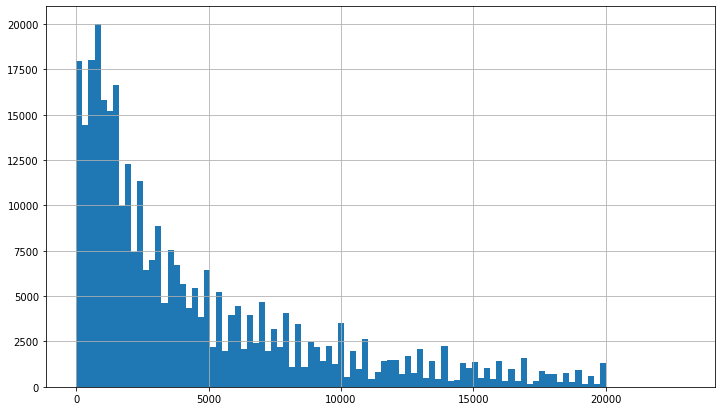

In [11]:
df['price'].hist(bins=100,range=(0,23000),figsize = (12,7))

<AxesSubplot:>

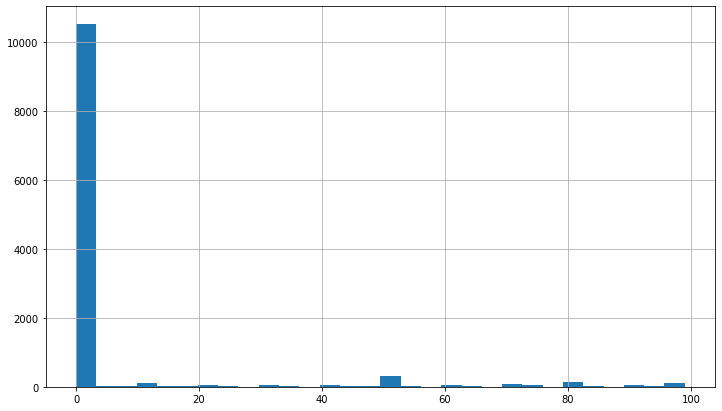

In [12]:
df[df['price']<100]['price'].hist(bins = 30, figsize = (12,7))

Цена 1 евро невозможна и эти данные будут меняшь обучению. Удалим их.

In [13]:
df = df[df['price']>1]

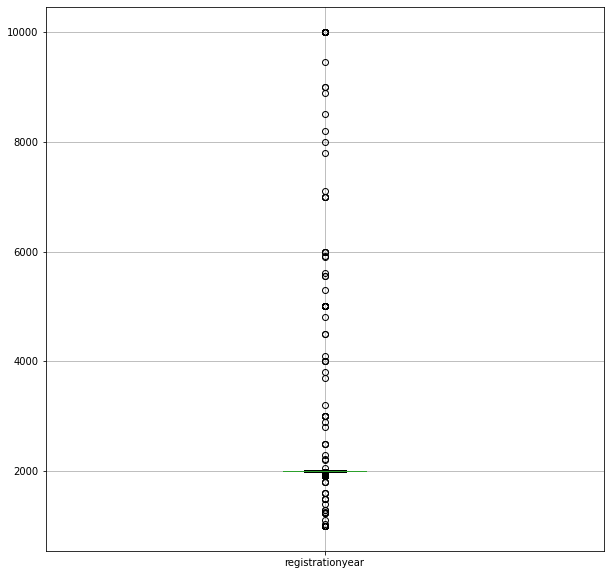

In [14]:
plot_by_registrationyear = df.boxplot('registrationyear',figsize=(10,10))

In [15]:
#Проверим какие значения могут быть допустимы для нашего датасета. Год регистрации автомобиля не может быть больше публикации объявления
df_before['datecreated'].value_counts().sort_index()

2014-03-10 00:00:00        1
2015-03-20 00:00:00        1
2015-06-18 00:00:00        1
2015-08-07 00:00:00        1
2015-08-10 00:00:00        1
                       ...  
2016-04-03 00:00:00    13719
2016-04-04 00:00:00    13317
2016-04-05 00:00:00     4104
2016-04-06 00:00:00     1105
2016-04-07 00:00:00      549
Name: datecreated, Length: 109, dtype: int64

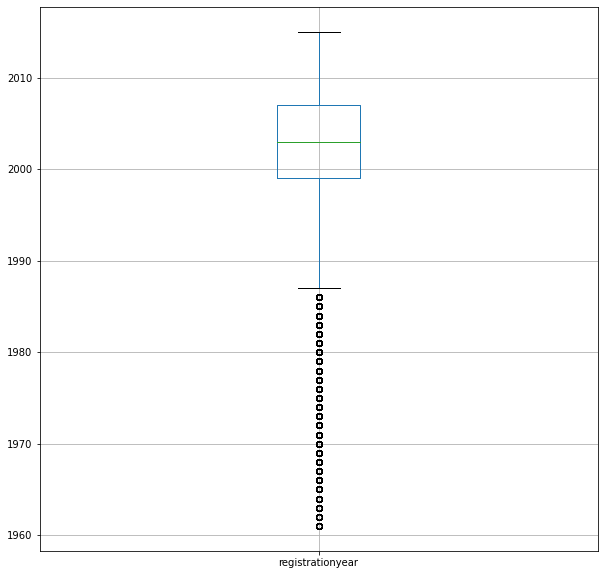

In [16]:
#Обрежем данные по году без выбросов.
df = df[(df['registrationyear']>1960) & (df['registrationyear']<2016)]
plot_by_registrationyear = df.boxplot('registrationyear',figsize=(10,10))

<AxesSubplot:>

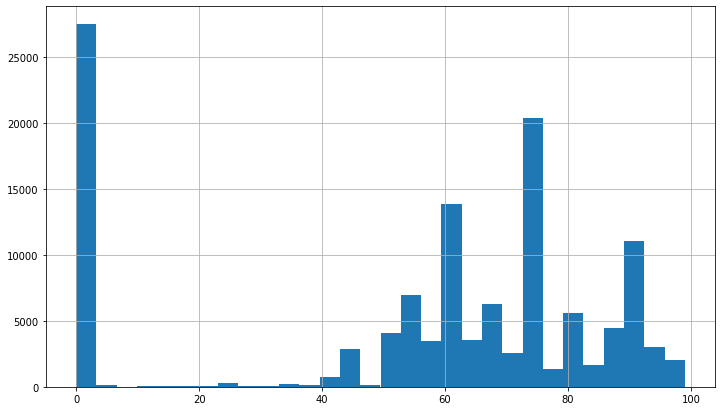

In [17]:
df[df['power']<100]['power'].hist(bins = 30, figsize = (12,7))

In [18]:
df['power'].value_counts().sort_index()

0        27471
1           21
2            8
3            8
4           26
         ...  
17932        1
19208        1
19211        1
19312        1
20000        1
Name: power, Length: 669, dtype: int64

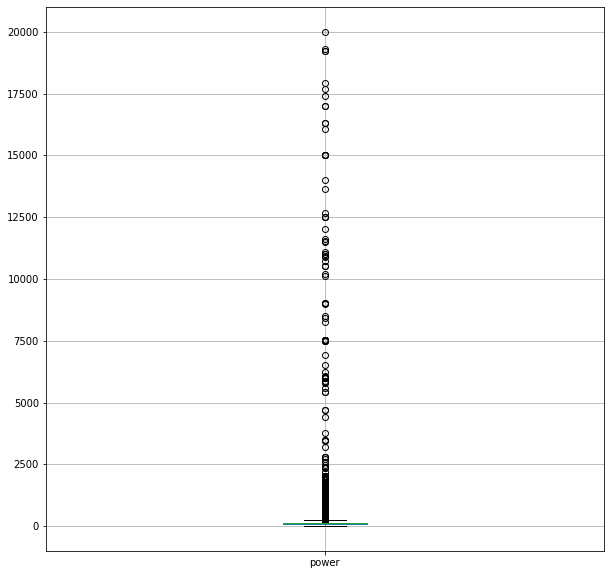

In [19]:
plot_by_power = df.boxplot('power',figsize=(10,10))

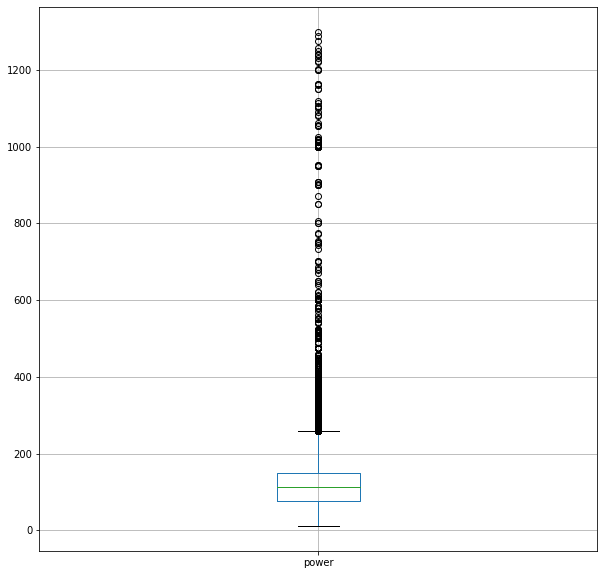

In [20]:
#удалим выбросы и оставим значения исходя из логики что серийных автомобилей более 1300 л.с не бывает.Так же удалим выбросы на нижней границе, автомобилей 
df = df[(df['power']>10) & (df['power']<1300)]
plot_by_power = df.boxplot('power',figsize=(10,10))

Все так же есть много автомобилей более 600 л.с, но эти данные могут быть реальными

In [21]:
df.isna().sum()

price                    0
vehicletype           4571
registrationyear         0
gearbox               4672
power                    0
model                 9730
kilometer                0
registrationmonth        0
fueltype             12543
brand                    0
repaired                 0
dtype: int64

Количество пропусков стало меньше, но остальные данные восстановить нет возможности, поэтому заполним их заглушкой 'unknown'

In [22]:
def patch(col):
    for i in col:
        df[i] = df[i].fillna('unknown')
patch(['vehicletype', 'fueltype', 'gearbox', 'model'])

In [23]:
df.isna().sum()

price                0
vehicletype          0
registrationyear     0
gearbox              0
power                0
model                0
kilometer            0
registrationmonth    0
fueltype             0
brand                0
repaired             0
dtype: int64

Мы будем обучать модель на LinearRegression, CatBoostRegressor, LGBMRegressor.  Только модель линейной регресии не поддерживает работу с категориальными признаками, поэтому для нее мы признакми переведем в номильнальные. У моделей CatBoostRegressor, LGBMRegressor есть поддержка работы с категориальными, поэтому для них мы скопируем датасет без изменений.

In [24]:
df_no_changes = df.copy()

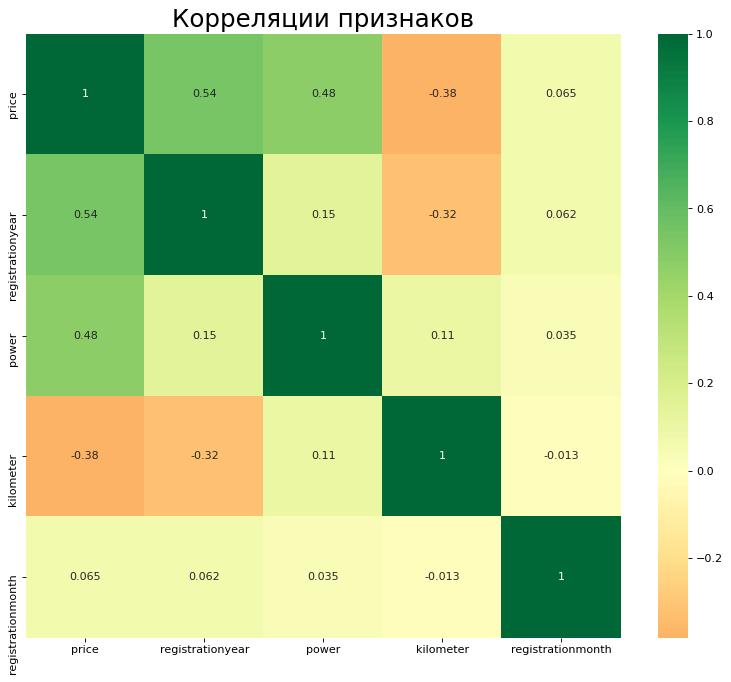

In [25]:
#проверим корреляцию признаков 
plt.figure(figsize=(12, 10), dpi=80)
sns.heatmap(df_no_changes.corr(), xticklabels=df_no_changes.corr().columns, yticklabels=df_no_changes.corr().columns, cmap='RdYlGn', center=0,annot=True)
plt.title('Корреляции признаков', fontsize=22)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

**Вывод по разделу подготовки и переработке:**

 - Удалены дубликаты и пустые значения.
 - Было произведено encoding категориальных значений
 - Удалены аномальные значения и выбросы
 - Провели кодирование признаков с помощью LabelEncoder

## Подготовка к обучение моделей

Разделим данные на обучающие и тестовые выборки для моделей которые работаю с категориальными данными и без них

In [26]:
features_categorical = df_no_changes.drop(['price'], axis=1)
target_categorical = df_no_changes['price']

#features_train_cat, features_test_cat, target_train_cat, target_test_cat = train_test_split(
#    features_categorical, target_categorical, test_size=0.3, random_state=1234)

In [27]:
#Отделение тестовой части
x_, features_test_, y_, target_test_ = train_test_split(features_categorical, target_categorical, test_size=0.2, train_size=0.8,random_state=12345)

#Отделения валидационной и обучающей выборки
features_train_, features_valid_, target_train_, target_valid_ = train_test_split(x_, y_, test_size = 0.25, train_size =0.75,random_state=12345)

In [28]:
#Проверка разделения
def check_size(data):
    row = len(data)/len(df)
    print('Процент выборки:', row)
    
data_list_ = [features_train_, features_valid_, target_train_, target_valid_, features_test_, target_test_]
for i in data_list_:
    check_size(i)

Процент выборки: 0.5999954951065595
Процент выборки: 0.20000225244672026
Процент выборки: 0.5999954951065595
Процент выборки: 0.20000225244672026
Процент выборки: 0.20000225244672026
Процент выборки: 0.20000225244672026


In [29]:
categories = ['brand', 'model', 'vehicletype', 'gearbox', 'fueltype', 'power','repaired']

In [30]:
features_train_[categories] = features_train_[categories].astype('category')
features_valid_[categories] = features_valid_[categories].astype('category')
features_test_[categories] = features_test_[categories].astype('category')


In [31]:
features = df.drop(['price'], axis=1)
target = df['price']


In [32]:
#Отделение тестовой части
x, features_test, y, target_test = train_test_split(features, target, test_size=0.2, train_size=0.8,random_state=12345)

#Отделения валидационной и обучающей выборки
features_train, features_valid, target_train, target_valid = train_test_split(x, y, test_size = 0.25, train_size =0.75,random_state=12345)

In [33]:
data_list = [features_train, features_valid, target_train, target_valid, features_test, target_test]

In [34]:
for i in data_list:
    check_size(i)

Процент выборки: 0.5999954951065595
Процент выборки: 0.20000225244672026
Процент выборки: 0.5999954951065595
Процент выборки: 0.20000225244672026
Процент выборки: 0.20000225244672026
Процент выборки: 0.20000225244672026


In [35]:
#в столбце model слишком много значений - преобразуем его методом ordinal

ord_encoder = OrdinalEncoder(handle_unknown= 'use_encoded_value', unknown_value = np.nan)
ord_encoder.fit(features_train[['model']])
features_train['model'] = ord_encoder.transform(features_train[['model']])
features_valid['model'] = ord_encoder.transform(features_valid[['model']])
features_test['model'] = ord_encoder.transform(features_test[['model']])


#приведем категориальные признаки в номинальные с помощью метода get_dummies (OHE)

ohe_list = ['vehicletype','gearbox', 'fueltype', 'brand', 'repaired']

ohe_hot_train = pd.get_dummies(features_train[ohe_list], drop_first=True)
features_train = features_train.drop(ohe_list,axis = 1)
features_train = features_train.join(ohe_hot_train, how='left')

ohe_hot_valid = pd.get_dummies(features_valid[ohe_list], drop_first=True)
features_valid = features_valid.drop(ohe_list,axis = 1)
features_valid = features_valid.join(ohe_hot_valid, how='left')

ohe_hot_test = pd.get_dummies(features_test[ohe_list], drop_first=True)
features_test = features_test.drop(ohe_list,axis = 1)
features_test = features_test.join(ohe_hot_test, how='left')


In [36]:
#проверим какие признаки входят во всех выборки
[i for i in list(features_train.columns) if (i in list(features_valid.columns) and (i in list(features_test.columns)))]

['registrationyear',
 'power',
 'model',
 'kilometer',
 'registrationmonth',
 'vehicletype_convertible',
 'vehicletype_coupe',
 'vehicletype_other',
 'vehicletype_sedan',
 'vehicletype_small',
 'vehicletype_suv',
 'vehicletype_unknown',
 'vehicletype_wagon',
 'gearbox_manual',
 'gearbox_unknown',
 'fueltype_electric',
 'fueltype_gasoline',
 'fueltype_hybrid',
 'fueltype_lpg',
 'fueltype_other',
 'fueltype_petrol',
 'fueltype_unknown',
 'brand_audi',
 'brand_bmw',
 'brand_chevrolet',
 'brand_chrysler',
 'brand_citroen',
 'brand_dacia',
 'brand_daewoo',
 'brand_daihatsu',
 'brand_fiat',
 'brand_ford',
 'brand_honda',
 'brand_hyundai',
 'brand_jaguar',
 'brand_jeep',
 'brand_kia',
 'brand_lada',
 'brand_lancia',
 'brand_land_rover',
 'brand_mazda',
 'brand_mercedes_benz',
 'brand_mini',
 'brand_mitsubishi',
 'brand_nissan',
 'brand_opel',
 'brand_peugeot',
 'brand_porsche',
 'brand_renault',
 'brand_rover',
 'brand_saab',
 'brand_seat',
 'brand_skoda',
 'brand_smart',
 'brand_sonstige_aut

In [37]:
#проверим одинаковые ли признаки во всех выборках
missed_test_columns = set(list(features_train.columns.values))-set(list(features_valid.columns.values))
display(missed_test_columns)
missed_test_columns = set(list(features_valid.columns.values))-set(list(features_test.columns.values))
display(missed_test_columns)
missed_test_columns = set(list(features_test.columns.values))-set(list(features_train.columns.values))
display(missed_test_columns)


set()

set()

set()

Лишних признаков в выборках нет. Все признаки, во всех выборках одинаковые.

In [38]:
#Применим StandardScaler для модели линейной регрессии

scaler = StandardScaler()
scaler.fit(features_train)
features_train = scaler.transform(features_train)
features_test = scaler.transform(features_test)
features_valid = scaler.transform(features_valid)

In [39]:
len(features_train[0])

62

Напишем функции для обучения, и проверки метрик моделей

In [40]:
def model_fit(model, features, target):
    start = time.time()
    
    try:
        model.fit(features, target, verbose=False)
    except:
        model.fit(features, target)
        
    end = time.time()
    
    return {'model':model, 'fit_time':(end-start)}

In [41]:
def model_predict(model, features):
    start = time.time()
    
    predictions = model.predict(features)
    end = time.time()
    
    return {'predictions':predictions, 'prediction_time':(end-start)}

In [42]:
def model_metrics(fit, prediction, rmse):
    print('Затраты время на обучения модели:', fit)
    print('Затраты время на предсказания:', prediction)
    print('RMSE =', rmse)

In [43]:
def rmse(predict, actual):
    predict = np.array(predict)
    actual = np.array(actual)

    distance = predict - actual

    square_distance = distance ** 2

    mean_square_distance = square_distance.mean()

    score = np.sqrt(mean_square_distance)

    return score

rmse_score = make_scorer(rmse, greater_is_better = False)

## Обучение моделей

**Обучим модел CatBoostRegressor**

In [44]:
model_сat = CatBoostRegressor(cat_features=categories)

In [45]:
fit_model_cat = model_fit(model_сat, features_train_, target_train_)

In [46]:
predict_model_cat = model_predict(model_сat, features_valid_)
rmse = mse(target_valid_, predict_model_cat.get('predictions'), squared=False)

In [47]:
print(fit_model_cat)

{'model': <catboost.core.CatBoostRegressor object at 0x7fc46367ca90>, 'fit_time': 163.09060168266296}


In [48]:
model_metrics(fit_model_cat.get('fit_time'), predict_model_cat.get('prediction_time'), rmse)

Затраты время на обучения модели: 163.09060168266296
Затраты время на предсказания: 0.428699254989624
RMSE = 1623.3109917275522


**Обучим модел LightGBM**

In [49]:
model_lgb = LGBMRegressor(cat_feature=categories)

In [50]:
fit_model_lgb = model_fit(model_lgb, features_train_, target_train_)

In [51]:
predict_model_lgb = model_predict(model_lgb, features_valid_)
rmse = mse(target_valid_, predict_model_lgb.get('predictions'), squared=False)

In [52]:
print(fit_model_lgb)

{'model': LGBMRegressor(cat_feature=['brand', 'model', 'vehicletype', 'gearbox',
                           'fueltype', 'power', 'repaired']), 'fit_time': 930.2489442825317}


In [53]:
model_metrics(fit_model_lgb.get('fit_time'), predict_model_lgb.get('prediction_time'), rmse)

Затраты время на обучения модели: 930.2489442825317
Затраты время на предсказания: 0.6180722713470459
RMSE = 1611.902990219231


**Обучим модел LinearRegression**

Так как для эта модель не умеет работать с категориальными прзнаками, будем использовать ранее подготовленные для этой модели данные с предварительны кодированием признаков

In [54]:
model_lr = LinearRegression()

In [55]:
fit_model_lr = model_fit(model_lr, features_train, target_train)

In [56]:
predict_model_lr = model_predict(model_lr, features_valid)
rmse = mse(target_valid, predict_model_lr.get('predictions'), squared=False)

In [57]:
print(fit_model_lr)

{'model': LinearRegression(), 'fit_time': 1.7346956729888916}


In [58]:
model_metrics(fit_model_lr.get('fit_time'), predict_model_lr.get('prediction_time'), rmse)

Затраты время на обучения модели: 1.7346956729888916
Затраты время на предсказания: 0.00403594970703125
RMSE = 2786.0183079307


**Сводные результаты по обучению моделей:** 

В ходе обучения модели CatBoostRegressor получены след данные:

- Затраты время на обучения модели: **163 сек**
- Затраты время на предсказания: **0.428 сек**
- RMSE = **1623.3109917275522**

В ходе обучения модели LightGBM получены след данные:

- Затраты время на обучения модели: **930 сек**
- Затраты время на предсказания: **0.618**
- RMSE = **1611.902990219231**

В ходе обучения модели LinearRegression получены след данные:

- Затраты время на обучения модели: **1.734 сек**
- Затраты время на предсказания: **0.004 сек**
- RMSE = **2786.0183079307**

**Вывод результаты по обучению моделей:** 

Модель LinearRegression быстро обучается и дает предсказания, но ключевая метрика RMSE очень высокая. Убираем эту модель из дальнейшего исследования.

Модели CatBoostRegressor и LightGBM имею близкие значения метрики RMSE, но разную скорость обучения. Изучим подробнее эти модели с подбором параметров.

## Анализ моделей

In [59]:
tuned_model_cat = CatBoostRegressor(loss_function='RMSE', 
                              iterations=500, 
                              learning_rate=0.2, 
                              thread_count=-1, 
                              max_depth=10, 
                              l2_leaf_reg=3.5,
                              cat_features=categories
                              )

In [60]:
tuned_fit_model_cat = model_fit(tuned_model_cat, features_train_, target_train_)

In [61]:
tuned_predict_model_cat = model_predict(tuned_model_cat, features_test_)

In [62]:
rmse = mse(target_test_, tuned_predict_model_cat.get('predictions'), squared=False)

In [63]:
model_metrics(tuned_fit_model_cat.get('fit_time'), tuned_predict_model_cat.get('prediction_time'), rmse)

Затраты время на обучения модели: 190.26983451843262
Затраты время на предсказания: 0.535872220993042
RMSE = 1584.2996379384308


In [64]:
tuned_model_lgb = LGBMRegressor(task='train', 
                        boosting_type='gbdt', 
                        objective='regression', 
                        metric='rmse', 
                        learning_rate=0.5, 
                        verbose=200, 
                        categorical_feature=categories)

In [65]:
tuned_fit_model_lgb = model_fit(tuned_model_lgb, features_train_, target_train_)

[LightGBM] [Warning] categorical_feature is set=brand,model,vehicletype,gearbox,fueltype,power,repaired, categorical_column=0,2,3,4,7,8,9 will be ignored. Current value: categorical_feature=brand,model,vehicletype,gearbox,fueltype,power,repaired
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.841539
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.184243
[LightGBM] [Debug] init for col-wise cost 0.191190 seconds, init for row-wise cost 0.003613 seconds
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.192876 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Dense Multi-Val Bin
[LightGBM] [Info] Total Bins 648
[LightGBM] [Info] Number of data points in the train set: 159825, number of used features: 10
[LightGBM] [Info] Start training from score 4891.478511
[LightGBM] [Debug] Trained a tree with l

In [66]:
tuned_predict_model_lgb = model_predict(tuned_model_lgb, features_test_)

In [67]:
rmse = mse(target_test_, tuned_predict_model_lgb.get('predictions'), squared=False)

In [68]:
model_metrics(tuned_fit_model_lgb.get('fit_time'), tuned_predict_model_lgb.get('prediction_time'), rmse)

Затраты время на обучения модели: 4.8896708488464355
Затраты время на предсказания: 0.40259647369384766
RMSE = 1612.5725362470166


Можем ли мы упростить обучение, не потеряв сильно в ключевой метрике RMSE?

**Исходя из полученных данных:**

 - для модели CatBoostRegressor получилось добиться лучшей метрики RMSE **1584**, но время обчуение выросло до 190 сек.
 - для модели LightGBM не получилось добиться улучшения метрик. Лучшее время обучение для модели составило - **4.889**сек. при метрике RMSE **1612**

## Вывод

 - Модели градиентного бустинга(Сatboost, LightBGM) показывают результаты значительно лучше линейной регрессии. Время обучение для этих моделей варьируется от 4.8 до 208 секунд в зависимости от параметров.
 - После улучшения модели Сatboost метрика RMSE выросла до лучших значений **1584** при скорости обучения 208 сек.
 - Модель LightGBM так же показывает относительно хорошую метрику **RMSE 1612** при скросости обучения 4.8 сек.
 - В зависимости от целей для бизнеса: скорость обучения  или важности высоких значений метрики RMSE,  можно выбрать модель которая будет максимально соответсовать задачам